# Pytorch Implementation of Legendre Memory Units, psMNIST Example

In [16]:
from typing import Tuple
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
def setSeed(seed):
    """ Set all seeds to ensure reproducibility """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def lecun_uniform_(tensor):
    """ 
        LeCun Uniform Initializer
        References: 
        [1] https://keras.rstudio.com/reference/initializer_lecun_uniform.html
        [2] Source code of _calculate_correct_fan can be found in https://pytorch.org/docs/stable/_modules/torch/nn/init.html
        [3] Yann A LeCun, Léon Bottou, Genevieve B Orr, and Klaus-Robert Müller. Efficient backprop. In Neural networks: Tricks of the trade, pages 9–48. Springer, 2012
    """
    fan_in = nn.init._calculate_correct_fan(tensor, "fan_in")
    limit = np.sqrt(3. / fan_in)
    return nn.init.uniform_(tensor, -limit, limit) # Fills the tensor with values sampled from U(-limit, limit)

def pytorch_cont2discrete_zoh(A, B, dt=1.0):
    em_upper = torch.cat((A, B), dim=1)
    # Need to stack zeros under the a and b matrices
    em_lower = torch.cat((torch.zeros((B.shape[1], B.shape[0]), dtype=A.dtype, device=A.device),
                          torch.zeros((B.shape[1], B.shape[1]), dtype=A.dtype, device=A.device)), dim=1)

    em = torch.cat((em_upper, em_lower), dim=0)
    ms = torch.linalg.matrix_exp(dt * em)

    # Dispose of the lower rows
    ms = ms[:A.shape[0], :]

    ad = ms[:, :A.shape[1]]
    bd = ms[:, A.shape[1]:]
    return ad.float(), bd.float()

def stateSpaceMatrices(memory_size, theta):
    """ Returns the discretized state space matrices A and B """

    Q = np.arange(memory_size, dtype = np.float64).reshape(-1, 1)
    R = (2*Q + 1) / theta
    i, j = np.meshgrid(Q, Q, indexing = "ij")

    # Continuous
    A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
    B = R * ((-1.0)**Q)
    C = np.ones((1, memory_size))
    D = np.zeros((1,))

    # Convert to discrete
    from scipy.signal import cont2discrete
    A, B, C, D, _ = cont2discrete(
        system = (A, B, C, D), 
        dt = 1.0, 
        method = "zoh"
    )
    
    return A, B


In [18]:
class LMUCell(nn.Module):
   """
      Implementation of LMU cell.

      The LMU cell consists of two parts: a memory component (decomposing
      the input signal using Legendre polynomials as a basis), and a hidden component
      (learning nonlinear mappings from the memory component). [1]_ [2]_

      This class processes one step within the whole time sequence input. Use the ``LMU``
      class to create a recurrent layer to process the whole sequence.

      References
      ----------
      .. [1] Voelker and Eliasmith (2018). Improving spiking dynamical
         networks: Accurate delays, higher-order synapses, and time cells.
         Neural Computation, 30(3): 569-609.
      .. [2] Voelker and Eliasmith. "Methods and systems for implementing
         dynamic neural networks." U.S. Patent Application No. 15/243,223.
         Filing date: 2016-08-22.
   """

   def __init__(
      self, 
      input_size, memory_d, order, theta, hidden_size, 
      nonlinearity=torch.tanh,
      init_ex=lecun_uniform_, init_eh=lecun_uniform_, init_em=nn.init.zeros_,
      init_Wx=nn.init.xavier_normal_, init_Wh=nn.init.xavier_normal_, init_Wm=nn.init.xavier_normal_,
      learn_A=False, learn_B=False
   ):
      super().__init__()
      self.memory_d = memory_d
      self.order = order
      self._init_theta = theta
      self.hidden_size = hidden_size
      self.nonlinearity_func = nonlinearity

      # Discretized state space matrices A and B
      A, B = self._gen_AB(order)
      if learn_A:
         self.A = nn.Parameter(A)
      else:
         self.register_buffer("A", A)
      if learn_B:
         self.B = nn.Parameter(B)
      else:
         self.register_buffer("B", B)

      # Learnable encoding vectors: Convert/project input and state features into the 
      # signal (e.g., u(t)) that writes to the memory (see equation (7) in the original paper).
      self.e_x = nn.Parameter(torch.empty(memory_d, input_size))
      self.e_h = nn.Parameter(torch.empty(memory_d, hidden_size))
      self.e_m = nn.Parameter(torch.empty(memory_d, order * memory_d))

      # Learnable Kernels: Learn to compute non-linear functions across the memory
      # (see equation (6) in the original paper).
      self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
      self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
      self.W_m = nn.Parameter(torch.empty(hidden_size, order * memory_d))

      # Initialize parameters
      init_ex(self.e_x)
      init_eh(self.e_h)
      init_em(self.e_m)
      init_Wx(self.W_x)
      init_Wh(self.W_h)
      init_Wm(self.W_m)


   def _gen_AB(self, order, dt=1.0):
      # Compute analog A/B matrices
      Q = torch.arange(order, dtype=torch.float64)
      R = (2 * Q + 1).unsqueeze(1)
      i, j = torch.meshgrid(Q, Q, indexing="ij")
      A = torch.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
      B = (-1.0) ** Q.unsqueeze(1) * R
      self.register_buffer("_base_A", A)
      self.register_buffer("_base_B", B)

      # Discretize
      return pytorch_cont2discrete_zoh(self._base_A / self._init_theta, self._base_B / self._init_theta, dt)


   def forward(self, x:torch.Tensor, state:Tuple[torch.Tensor, torch.Tensor]):
      # x: [batch_size, input_size]
      # h: [batch_size, hidden_size]
      # m: [batch_size, memory_d*order]
      h, m = state
      
      u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m) # equation (7) in the original paper

      m = m.reshape(-1, self.memory_d, self.order)
      u = u.unsqueeze(-1)

      m = F.linear(m, self.A) + F.linear(u, self.B) # equation (4) in the original paper
      m = m.reshape(-1, self.memory_d * self.order)
      
      h = self.nonlinearity_func(
         F.linear(x, self.W_x) + 
         F.linear(h, self.W_h) + 
         F.linear(m, self.W_m)
      ) # equation (6) in the original paper
      return h, m


class LMUCellOld(nn.Module):
    def __init__(self, input_size, hidden_size, memory_size, theta):        
        super().__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.f = nn.Tanh()

        A, B = stateSpaceMatrices(memory_size, theta)
        A = torch.from_numpy(A).float()
        B = torch.from_numpy(B).float()

        self.register_buffer("A", A)
        self.register_buffer("B", B)

        # Declare Model parameters:
        ## Encoding vectors
        self.e_x = nn.Parameter(torch.empty(1, input_size))
        self.e_h = nn.Parameter(torch.empty(1, hidden_size))
        self.e_m = nn.Parameter(torch.empty(1, memory_size))
        ## Kernels
        self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.W_m = nn.Parameter(torch.empty(hidden_size, memory_size))

        self.initParameters()


    def initParameters(self):
      # Initialize encoders
      lecun_uniform_(self.e_x)
      lecun_uniform_(self.e_h)
      nn.init.zeros_(self.e_m)
      # Initialize kernels
      nn.init.xavier_normal_(self.W_x)
      nn.init.xavier_normal_(self.W_h)
      nn.init.xavier_normal_(self.W_m)


    def forward(self, x, state):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, input_size]
            state (tuple): 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """

        h, m = state

        # Equation (7) of the paper
        u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m) # [batch_size, 1]

        # Equation (4) of the paper
        m_new = F.linear(m, self.A) + F.linear(u, self.B) # [batch_size, memory_size]

        # Equation (6) of the paper
        h_new = self.f(
            F.linear(x, self.W_x) +
            F.linear(h, self.W_h) + 
            F.linear(m_new, self.W_m)
        ) # [batch_size, hidden_size]

        return h_new, m_new


In [32]:

# Quick test to make sure this works the same way as the old version
SEED = 0
theta = 784
memory_d = 1
order = 256
hidden_size = 212

setSeed(SEED)
lmu_cell = LMUCell(1, memory_d, order, theta, hidden_size)
test_input0 = torch.randn(1,1)
test_input1 = torch.randn(1,1)
test_state = (torch.zeros(1, hidden_size), torch.zeros(1, order*memory_d)) # h, m
h0, m0 = lmu_cell(test_input0, test_state)
h1, m1 = lmu_cell(test_input1, (h0, m0))
#print(h)

setSeed(SEED)
lmu_cell_old = LMUCellOld(1, hidden_size, memory_d*order, theta)
test_input0 = torch.randn(1,1)
test_input1 = torch.randn(1,1)
test_state = (torch.zeros(1, hidden_size), torch.zeros(1, order*memory_d)) # h, m
h0_old, m0_old = lmu_cell_old(test_input0, test_state)
h1_old, m1_old = lmu_cell_old(test_input1, (h0_old, m0_old))
#print(h)

torch.isclose(h0, h0_old).all(), torch.isclose(m0, m0_old).all(), torch.isclose(h1, h1_old).all(), torch.isclose(m1, m1_old).all()

(tensor(True), tensor(True), tensor(True), tensor(True))

In [20]:
class LMU(nn.Module):
    def __init__(
        self,
        input_size, memory_d, order, theta, hidden_size, 
        nonlinearity=torch.tanh,
        init_ex=lecun_uniform_, init_eh=lecun_uniform_, init_em=nn.init.zeros_,
        init_Wx=nn.init.xavier_normal_, init_Wh=nn.init.xavier_normal_, init_Wm=nn.init.xavier_normal_
    ):
        super(LMU, self).__init__()
        self.hidden_size = hidden_size
        self.memory_d = memory_d
        self.order = order
        self.lmu_cell = LMUCell(
            input_size, memory_d, order, theta, hidden_size, nonlinearity, 
            init_ex, init_eh, init_em, init_Wx, init_Wh, init_Wm
        )

    def forward(self, x:torch.Tensor, state:Tuple[torch.Tensor, torch.Tensor]|None=None):
        batch_size = x.size(0)
        seq_len    = x.size(1)

        if state == None:
            h_0 = torch.zeros(batch_size, self.hidden_size).to(x.device)
            m_0 = torch.zeros(batch_size, self.order * self.memory_d).to(x.device)
            state = (h_0, m_0)

        # Iterate over the timesteps
        output = []
        for t in range(seq_len):
            x_t = x[:, t, :] # [batch_size, input_size]
            h_t, m_t = self.lmu_cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)
        
        output = torch.stack(output) # [seq_len, batch_size, hidden_size]
        output = output.permute(1, 0, 2)
        return output, state # state is the last output state of the sequence
    

class LMUOld(nn.Module):
    """ An LMU layer """

    def __init__(self, input_size, hidden_size, memory_size, theta):
        """
        Parameters:
            input_size (int) : 
                Size of the input vector (x_t)
            hidden_size (int) : 
                Size of the hidden vector (h_t)
            memory_size (int) :
                Size of the memory vector (m_t)
            theta (int) :
                The number of timesteps in the sliding window that is represented using the LTI system
            learn_a (boolean) :
                Whether to learn the matrix A (default = False)
            learn_b (boolean) :
                Whether to learn the matrix B (default = False)
            psmnist (boolean) :
                Uses different parameter initializers when training on psMNIST (as specified in the paper)
        """

        super(LMUOld, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.cell = LMUCellOld(input_size, hidden_size, memory_size, theta)


    def forward(self, x, state = None):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, seq_len, input_size]
            state (tuple) : (default = None) 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """
        
        # Assuming batch dimension is always first, followed by seq. length as the second dimension
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initial state (h_0, m_0)
        if state == None:
            h_0 = torch.zeros(batch_size, self.hidden_size)
            m_0 = torch.zeros(batch_size, self.memory_size)
            if x.is_cuda:
                h_0 = h_0.cuda()
                m_0 = m_0.cuda()
            state = (h_0, m_0)

        # Iterate over the timesteps
        output = []
        for t in range(seq_len):
            x_t = x[:, t, :] # [batch_size, input_size]
            h_t, m_t = self.cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)

        output = torch.stack(output) # [seq_len, batch_size, hidden_size]
        output = output.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]

        return output, state # state is (h_n, m_n) where n = seq_len

In [21]:
setSeed(SEED)
lmu = LMU(1, memory_d, order, theta, hidden_size)
test_input = torch.randn(100, theta, 1)
output, state = lmu(test_input)

setSeed(SEED)
lmu_old = LMUOld(1, hidden_size, memory_d*order, theta)
test_input = torch.randn(100, theta, 1)
output_old, state_old = lmu_old(test_input)

torch.isclose(output, output_old).all(), torch.isclose(state[0], state_old[0]).all(), torch.isclose(state[1], state_old[1]).all()

(tensor(True), tensor(True), tensor(True))

## Example: psMNIST

In [22]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [23]:
INPUT_DIM = 1    # Dimension of the input, a single pixel
MEM_D = 1        # Dimension of the memory
THETA = 784      # Length of the memory window
HIDDEN_DIM = 212 # Dimension of the hidden state
ORDER = 256      # Order/Size (Legendre Coefficients) of the memory
NUM_CLASSES = 10 # Number of classes
BATCH_SIZE = 100 # Batch size
EPOCHS = 10      # Number of epochs

# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted 
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"

setSeed(0)

In [24]:
class psMNIST(Dataset):
    """ Dataset that defines the psMNIST dataset, given the MNIST data and a fixed permutation """

    def __init__(self, mnist, perm):
        self.mnist = mnist # also a torch.data.Dataset object
        self.perm  = perm

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        unrolled = img.reshape(-1)
        permuted = unrolled[self.perm]
        permuted = permuted.reshape(-1, 1)
        return permuted, label

class Model(nn.Module):
    """ A simple model for the psMNIST dataset consisting of a single LMU layer and a single dense classifier """

    def __init__(self, input_size, output_size, hidden_size, order, theta):
        super(Model, self).__init__()
        self.lmu = LMU(input_size, MEM_D, order, theta, hidden_size, 
                       init_ex=lecun_uniform_, init_eh=nn.init.zeros_, init_em=nn.init.zeros_,
                       init_Wx=nn.init.zeros_, init_Wh=nn.init.zeros_, init_Wm=nn.init.xavier_normal_)
        
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lmu(x) # [batch_size, hidden_size]
        output = self.classifier(h_n)
        return output # [batch_size, output_size]

In [25]:
def disp(img):
    """ Displays an image """
    if len(img.shape) == 3:
        img = img.squeeze(0)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def dispSeq(seq, rows = 8):
    """ Displays a sequence of pixels """
    seq = seq.reshape(rows, -1) # divide the 1D sequence into `rows` rows for easy visualization
    disp(seq)
    
def countParameters(model):
    """ Counts and prints the number of trainable and non-trainable parameters of a model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

def accuracy_score(y_true, y_pred):
    """ Computes the accuracy of the predictions """
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

In [26]:
def train(model, loader, optimizer, criterion):
    """ A single training epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.train()
    progress_bar = tqdm(loader)
    for batch, labels in progress_bar:

        torch.cuda.empty_cache()

        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)

        optimizer.zero_grad()

        output = model(batch)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        preds  = output.argmax(dim = 1)
        preds_list = preds.tolist()
        labels_list = labels.tolist()
        y_pred += preds_list
        y_true += labels_list
        epoch_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}, Acc: {accuracy_score(labels_list, preds_list):.4f}")

    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

def validate(model, loader, criterion):
    """ A single validation epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        progress_bar = tqdm(loader)
        for batch, labels in progress_bar:

            torch.cuda.empty_cache()

            batch = batch.to(DEVICE)
            labels = labels.long().to(DEVICE)

            output = model(batch)
            loss = criterion(output, labels)
            
            preds  = output.argmax(dim = 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()
            epoch_loss += loss.item()
            
            
    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [27]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST("", train = True, download = True, transform = transform)
mnist_val   = datasets.MNIST("", train = False, download = True, transform = transform)

perm = torch.load("permutation.pt").long() # created using torch.randperm(784)
ds_train = psMNIST(mnist_train, perm)
ds_val   = psMNIST(mnist_val, perm) 

dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True)
dl_val   = DataLoader(ds_val, batch_size = BATCH_SIZE, shuffle = True)

Label: 5


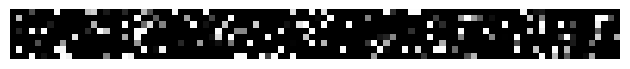

In [28]:
# Example of the data
eg_img, eg_label = ds_train[0]
print("Label:", eg_label)
dispSeq(eg_img)

#### Model

In [29]:
model = Model(INPUT_DIM, NUM_CLASSES, HIDDEN_DIM, ORDER, THETA).to(DEVICE)
optimizer = optim.Adam(params = model.parameters())
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

countParameters(model) # as stated in the paper, the model has ≈102K parameters

The model has 102,027 trainable parameters and 0 frozen parameters


In [30]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
   
    print(f"Epoch: {epoch+1:02}/{EPOCHS:02}")

    train_loss, train_acc = train(model, dl_train, optimizer, criterion)
    val_loss, val_acc = validate(model, dl_val, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")
    print()

Epoch: 01/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.690 | Train Acc: 78.19%
Val. Loss: 0.370 |  Val. Acc: 89.32%

Epoch: 02/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.309 | Train Acc: 90.65%
Val. Loss: 0.227 |  Val. Acc: 93.17%

Epoch: 03/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.204 | Train Acc: 93.82%
Val. Loss: 0.165 |  Val. Acc: 95.14%

Epoch: 04/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.147 | Train Acc: 95.48%
Val. Loss: 0.154 |  Val. Acc: 95.32%

Epoch: 05/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.119 | Train Acc: 96.33%
Val. Loss: 0.122 |  Val. Acc: 96.01%

Epoch: 06/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.092 | Train Acc: 97.14%
Val. Loss: 0.112 |  Val. Acc: 96.30%

Epoch: 07/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.076 | Train Acc: 97.61%
Val. Loss: 0.112 |  Val. Acc: 96.52%

Epoch: 08/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.064 | Train Acc: 97.95%
Val. Loss: 0.112 |  Val. Acc: 96.64%

Epoch: 09/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.053 | Train Acc: 98.33%
Val. Loss: 0.095 |  Val. Acc: 97.13%

Epoch: 10/10


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.057 | Train Acc: 98.25%
Val. Loss: 0.660 |  Val. Acc: 78.07%



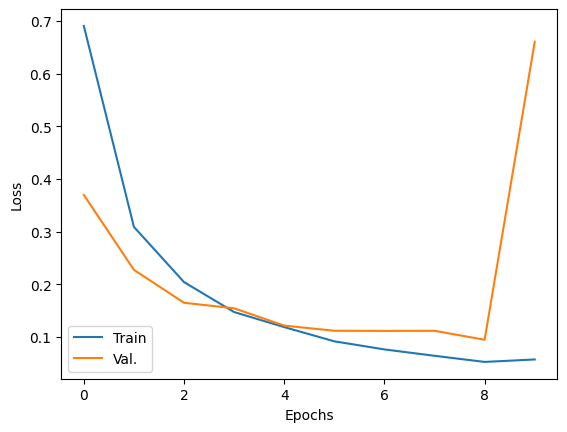

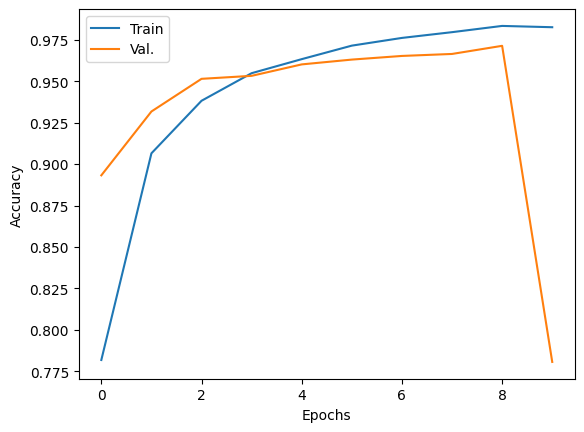

In [31]:
# Learning curves
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

plt.plot(range(len(train_accs)), train_accs)
plt.plot(range(len(val_accs)), val_accs)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()